In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

In [2]:
data = pd.read_csv('Retail Sales.csv')
df = pd.DataFrame(data)
df

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu
...,...,...,...,...,...,...,...,...,...,...,...
9989,OD9990,Sudeep,"Eggs, Meat & Fish",Eggs,Madurai,12/24/2015,West,945,0.16,359.10,Tamil Nadu
9990,OD9991,Alan,Bakery,Biscuits,Kanyakumari,07-12-2015,West,1195,0.26,71.70,Tamil Nadu
9991,OD9992,Ravi,Food Grains,Rice,Bodi,06-06-2017,West,1567,0.16,501.44,Tamil Nadu
9992,OD9993,Peer,Oil & Masala,Spices,Pudukottai,10/16/2018,West,1659,0.15,597.24,Tamil Nadu


In [3]:
sales = df.groupby('Order Date')['Sales'].sum()
profit = df.groupby('Order Date')['Profit'].sum()
main = pd.merge(sales, profit, on='Order Date')
main= main.reset_index(drop=False)
main

,Order Date,Sales,Profit
0,01-01-2018,19111,6207.78
1,01-02-2016,12663,2754.73
2,01-02-2017,1152,190.33
3,01-02-2018,13358,3587.50
4,01-03-2015,864,380.16
...,...,...,...
1231,9/29/2017,15639,4185.96
1232,9/29/2018,37084,8980.00
1233,9/30/2015,6790,826.98
1234,9/30/2017,2821,649.46


In [4]:
date_formats = ['%m/%d/%Y', '%m-%d-%Y', '%Y-%m-%d']
parsed_dates = []

for date_str in main['Order Date']:
    for date_format in date_formats:
        try:
            parsed_date = pd.to_datetime(date_str, format=date_format)
            parsed_dates.append(parsed_date)
            break
        except ValueError:
            pass

main['Parsed Date'] = parsed_dates

In [5]:
main = main[['Parsed Date','Sales','Profit']]
main = main.iloc[:-12]

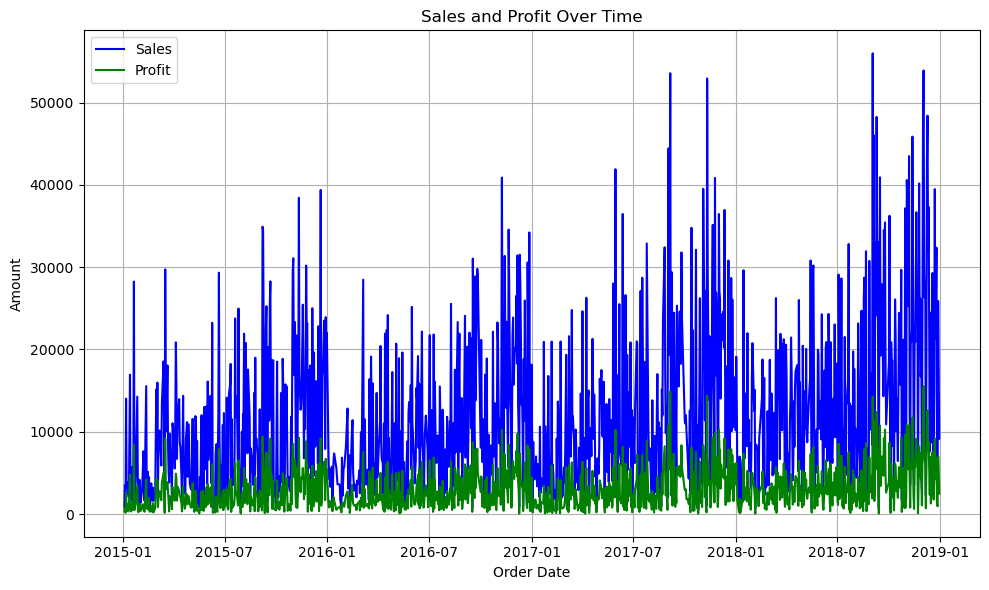

In [6]:
main['Parsed Date'] = pd.to_datetime(main['Parsed Date'])
main = main.sort_values(by='Parsed Date')


plt.figure(figsize=(10, 6))
plt.plot(main['Parsed Date'], main['Sales'], label='Sales', color='blue')
plt.plot(main['Parsed Date'], main['Profit'], label='Profit', color='green')


plt.title('Sales and Profit Over Time')
plt.xlabel('Order Date')
plt.ylabel('Amount')
plt.legend()


plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
df = pd.DataFrame(main)
X=df['Profit'].values.reshape(-1,1)
y=df['Sales'].values

In [8]:
in_seq1 = df['Profit'].values
in_seq2 = df['Sales'].values

in_seq1 = in_seq1.reshape((len(in_seq1),1))
in_seq2 = in_seq2.reshape((len(in_seq2),1))

dataset = np.hstack((in_seq1,in_seq2))


In [9]:
def split_sequences(sequences, n_steps, n_steps_out):
    X, y = [],[]
    for i in range(len(sequences)):
        end_ix = i + n_steps_out
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix,:],sequences[end_ix:out_end_ix,:]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 4,3
X, y = split_sequences(dataset, n_steps_in,n_steps_out)
print(X.shape, y.shape)
        

(1219, 3, 2) (1219, 3, 2)


In [10]:
last_4_rows = main.tail(4)[['Sales', 'Profit']].values.tolist() 
print(last_4_rows)

[[3575.0, 937.97], [25875.0, 7046.21], [16932.0, 5258.59], [9152.0, 2487.23]]


In [13]:
n_features = X.shape[2]
model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(n_steps_in, n_features))) 
model.add(RepeatVector(n_steps_out))
model.add(LSTM(300, activation='relu', return_sequences=True)) 
model.add(TimeDistributed(Dense(n_features))) # Use n_features as the number of units in the dens model.compile(optimizer='adam', loss='mse'
model.compile(optimizer='adam', loss='mse')

In [14]:
num_iterations = 3
results = [] # To store the results
for _ in range(num_iterations): 
    while True:
        # Fit the model
        model.fit(X, y, epochs=300, verbose=0)
        print(_)
        # Demonstrate prediction
        x_input = array(last_4_rows)
        n_input_timesteps = x_input.shape[0] # Number of input timesteps
        x_input = x_input.reshape((1, n_input_timesteps, n_features)) # Reshape the input yhat = model.predict(x_input, verbose=0)
        output = yhat.reshape((1, n_steps_out, n_features)) 
        
        if np.all(output > 0):
            break # Exit the while loop if all elements of the output are positive print(output)
    print(output)
    results.append(output)
    
average_result = np.mean(results, axis=0)
print(average_result)
print("done")

ValueError: in user code:

    File "/Users/jeffrytroll/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/Users/jeffrytroll/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/jeffrytroll/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/Users/jeffrytroll/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/Users/jeffrytroll/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/jeffrytroll/anaconda3/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 4, 2), found shape=(None, 3, 2)
